# Z- max projection across in-focus planes

This notebook accepts a dataset and write z max projections

1. the dataset folder is structured: raw | projected | out
1. only the focal planes (highest x-y std projection) are used for the z max projection
1. the generated tiff files are saved as 16bit CxWxH ome.tiff files in the `projected` folder

Remark: the user is asked to make some decisions based on the helper plots (for instance, the threshold and the channel to use for sharpness evaluation)

In [139]:
from pathlib import Path
from pprint import pprint

from matplotlib import pyplot as plt

import tifffile as tf
import numpy as np
import cv2

from centrack import sharp_planes, image_8bit_contrast

In [140]:
# Create directory variables
path_root = Path('/Volumes/work/datasets/')
# RPE1wt_CEP152+GTU88+PCNT_1
# RPE1wt_CEP63+CETN2+PCNT_1
dataset_name = input("Enter the name of the dataset")

path_raw = path_root / dataset_name / 'raw'

path_projections = path_root / dataset_name / 'projected'
path_projections.mkdir(exist_ok=True)

# Collect the ome.tiff files
files = sorted(tuple(file for file in path_raw.iterdir() 
                     if file.name.endswith('.tif') 
                     if not file.name.startswith('.')))

Enter the name of the dataset RPE1wt_CEP63+CETN2+PCNT_1


In [141]:
# Load a sample file to refine parameters
path_master_file = files[0]
print(path_master_file)
fov = tf.imread(path_master_file)

/Volumes/work/datasets/RPE1wt_CEP63+CETN2+PCNT_1/raw/gfp.tif


In [80]:
target_dims = (4, 67, 2048, 2048)

In [122]:
# reshaped = fov.flatten().reshape(target_dims)
reshaped = np.expand_dims(fov, 0)
# reshaped = np.moveaxis(fov, 0, 1)

In [82]:
assert reshaped.shape == target_dims, f"Not the same dimensions {fov.shape}; target={target_dims}"

In [146]:
markers = dataset_name.split('_')[-2].split('+')
if 'DAPI' not in markers:
    markers = ['DAPI'] + markers
markers_map = list(zip(range(len(markers)), markers))
print(f"{dataset_name} => {markers_map}")

RPE1wt_CEP63+CETN2+PCNT_1 => [(0, 'DAPI'), (1, 'CEP63'), (2, 'CETN2'), (3, 'PCNT')]


(67,) (1, 2048, 2048)


IndexError: index 1 is out of bounds for axis 0 with size 1

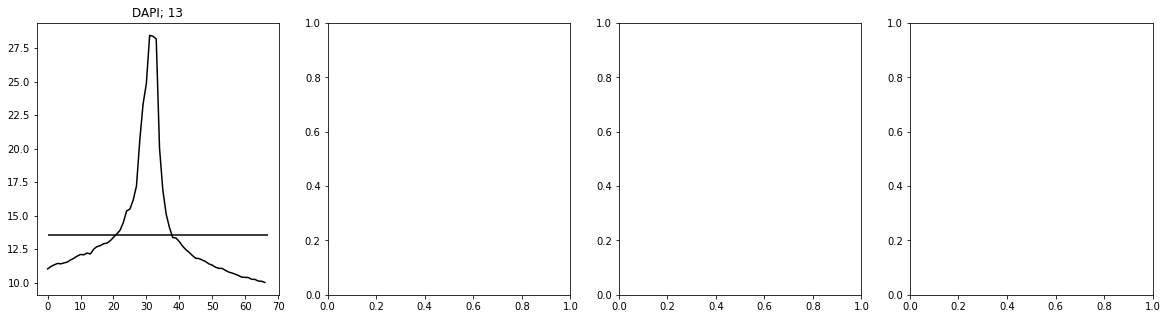

In [147]:
channels_n = reshaped.shape[0]
depth_n = reshaped.shape[1]
fig, axs = plt.subplots(ncols=len(markers), figsize=(20, 5))

for i, name in markers_map:
    ax = axs[i]
    profile, projected = sharp_planes(reshaped,
                                      shape=target_dims, 
                                      reference_channel=i, 
                                      threshold=0)
    ax.plot(profile, 'k')
    ax.hlines(profile.mean(), 0, depth_n, colors='k')
    ax.set_title(f"{name}; {int(profile.mean())}")

In [148]:
channel_id = int(input("Please enter the channel"))
threshold = int(input("Please enter the threshold"))

Please enter the channel 0
Please enter the threshold 13


In [153]:
for f, file in enumerate(files):
    print(f"Loading {file.name}")
    fov = tf.imread(path_raw / file.name)
    reshaped = np.expand_dims(fov, 0)
#     reshaped = np.moveaxis(fov, 0, 1)
#     reshaped = fov.flatten().reshape(target_dims)
#     profile, projected = sharp_planes(reshaped, 
#                                       shape=target_dims, 
#                                       reference_channel=channel_id, 
#                                       threshold=threshold)
    projected = reshaped.max(1)
    tf.imwrite(path_projections / file.name, projected)

Loading gfp.tif


In [152]:
fov.shape

(67, 2048, 2048)